# 임베딩 모델

https://huggingface.co/jinaai/jina-embeddings-v3

jina-embeddings-v3 모델을 사용한다
1. 상위권에 존재
2. Max Tokens값이 많아 줄거리와 같은 긴 글에 적합해보였다
3. 10월 2일 기준 Zero-shot이 100%로 높았다

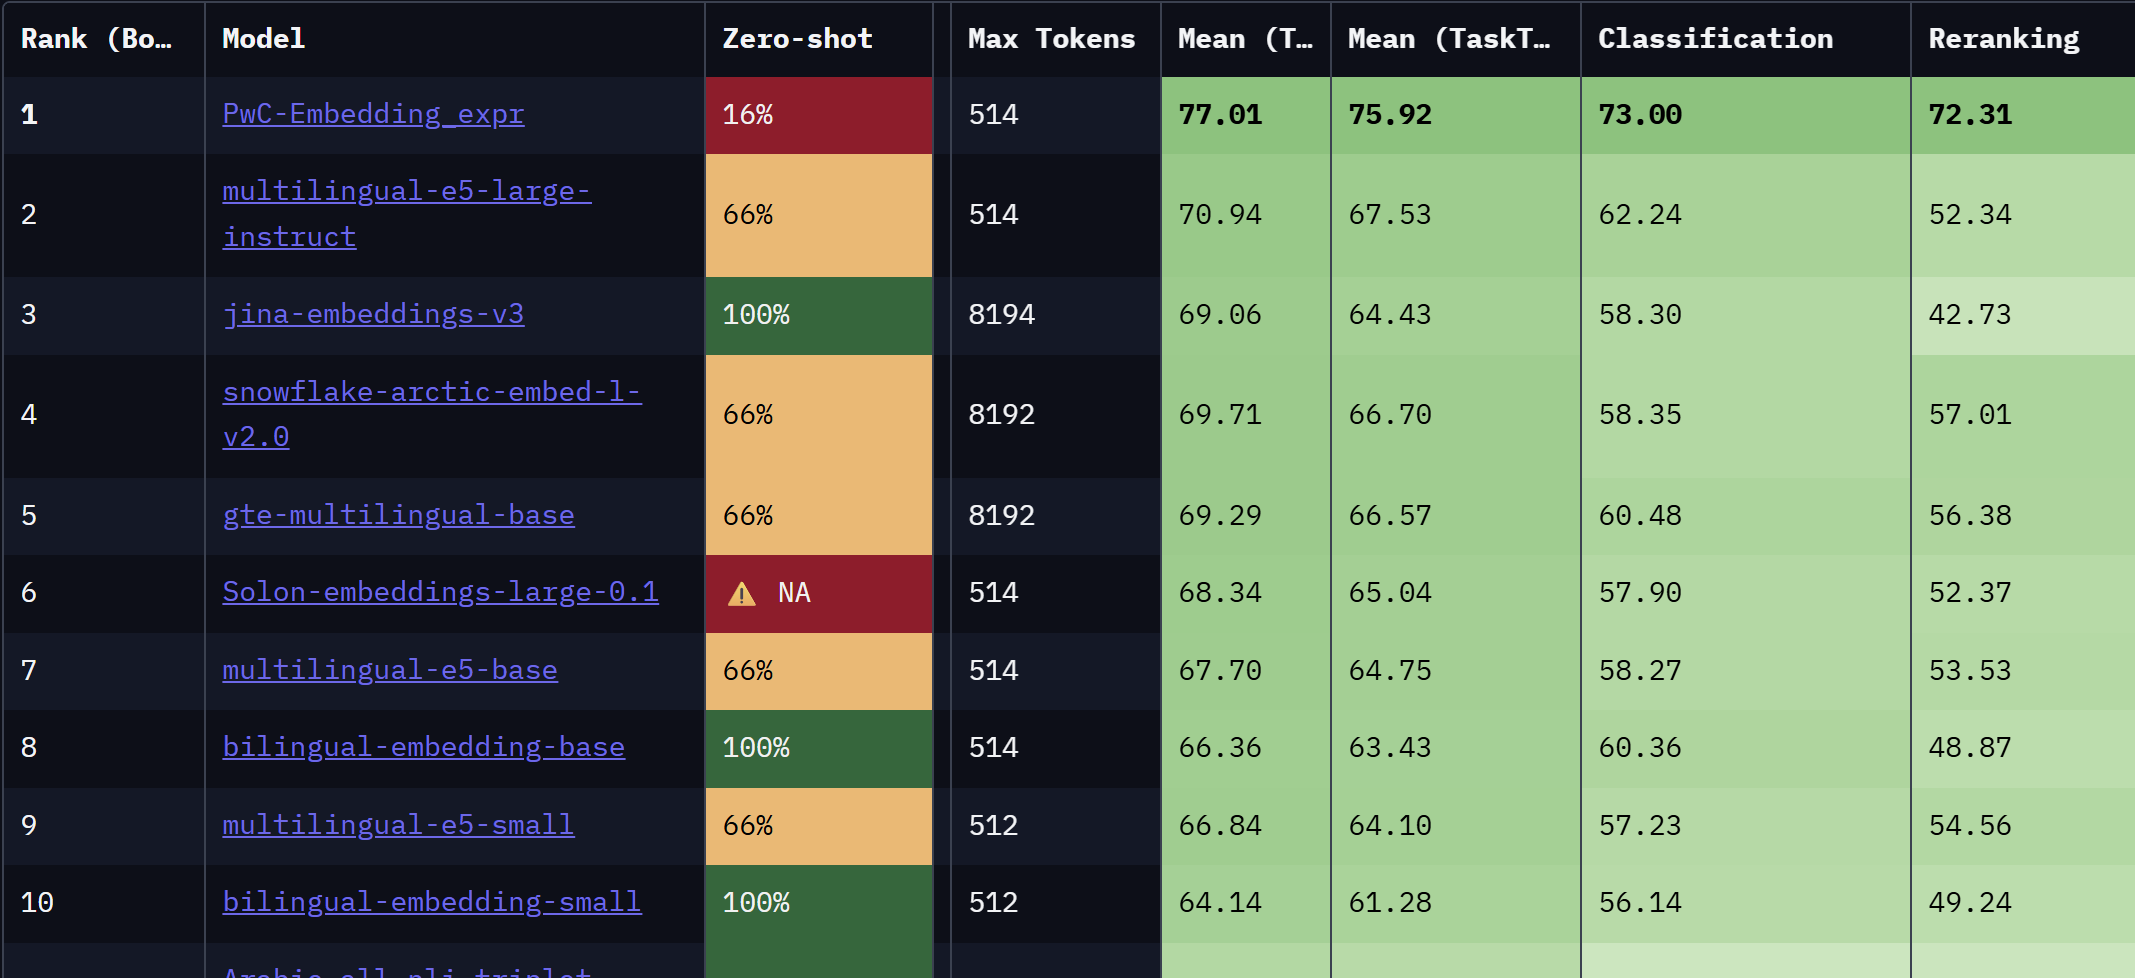

# Colab에서 진행

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
pip install --upgrade torch einops tokenizers sentence_transformers

## 모델 다운로드

In [13]:
from sentence_transformers import SentenceTransformer
import torch

# 디바이스 설정 (GPU가 있으면 cuda, 없으면 cpu)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# SentenceTransformer로 모델 로드, trust_remote_code=True는 필수
model = SentenceTransformer("jinaai/jina-embeddings-v3", trust_remote_code=True, device=device)

texts = [
    "Follow the white rabbit.",  # English
    "Sigue al conejo blanco.",  # Spanish
    "Suis le lapin blanc.",  # French
    "跟着白兔走。",  # Chinese
    "اتبع الأرنب الأبيض.",  # Arabic
    "Folge dem weißen Kaninchen.",  # German
]

# SentenceTransformer의 encode 함수 사용
embeddings = model.encode(texts, task="text-matching")

print("임베딩 성공!")
print(embeddings.shape)

Using device: cuda


임베딩 성공!
(6, 1024)


## 임베딩 진행

In [14]:
import pandas as pd

In [15]:
movie_info = pd.read_csv("/content/drive/MyDrive/비어플/25-2/movie_info_data.csv", encoding="utf-8-sig")

In [16]:
movie_info.columns

Index(['Movie_Title', 'Main_Country', 'Grade', 'now_showing', 'director1',
       'director2', 'director3', 'director4', 'director5', 'actor1', 'actor2',
       'actor3', 'actor4', 'actor5', 'actor6', 'movie_summary',
       'Distributor_1', 'Distributor_2', 'Distributor_3', 'Distributor_4',
       'Distributor_5', 'Distributor_6', 'Distributor_7', 'Distributor_8',
       'genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7'],
      dtype='object')

In [17]:
summary_embedding=movie_info[["Movie_Title", "movie_summary"]]

In [18]:
summary_texts = summary_embedding["movie_summary"].tolist()

In [19]:
summary_texts[2]

'평범한 집처럼 꾸며진 3개의 세트장, 12살로 설정한 페이크 계정을 만들고 컴퓨터 모니터 앞에 선 배우들. 계정 계설과 동시에 전 세계 남성이 접촉해왔으며 열흘 간 나체사진 요구, 가스라이팅, 협박, 그루밍 등을 시도하는 남성은 총 2,458명이었다. 그리고 우린 그 중 21명과 대면하게 된다.  범죄의 형식이 온라인으로 확산된 언택트 시대. 성에 대한 가치관이 형성되지 않은 아동·청소년들에게 일어나는 충격적인 디지털 성범죄를 추적한다. 그리고, 가해자들의 처벌까지 이어질 수 있을까?  디지털 성범죄자 검거 프로젝트  <#위왓치유>'

## Task-Specific Embedding

- `retrieval.query`: Used for query embeddings in asymmetric retrieval tasks
- `retrieval.passage`: Used for passage embeddings in asymmetric retrieval tasks
- `separation`: Used for embeddings in clustering and re-ranking applications
- `classification`: Used for embeddings in classification tasks
- `text-matching`: Used for embeddings in tasks that quantify similarity between two texts, such as STS or symmetric retrieval tasks

클러스터링의 상황에 적합한 `separation`을 사용한다

## Matryoshka Embeddings을 통한 차원 축소

1024차원 그대로 진행하면 다른 메타데이터 벡터(장르, 등급 등)와 크기차이가 큼으로 차원축소를 진행하여야 한다.  
PCA를 통해 줄일 수 있지만, 마트료시카 임베딩 기능이 해당 모델에 있으므로 이것을 사용하다.  
자동으로 중요한 정보일수록 순서를 앞으로 뺀다.

### 256차원 임베딩

In [26]:
embeddeing_256 = model.encode(summary_texts, task="separation", show_progress_bar=True, batch_size=8, truncate_dim=256)

Batches:   0%|          | 0/593 [00:00<?, ?it/s]

In [31]:
summary_embedding['summary_256'] = list(embeddeing_256)

/tmp/ipython-input-1231944732.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_embedding['summary_256'] = list(embeddeing_256)


### 128차원 임베딩

In [35]:
embeddeing_128 = model.encode(summary_texts, task="separation", show_progress_bar=True, batch_size=8, truncate_dim=128)
summary_embedding['summary_128'] = list(embeddeing_128)

Batches:   0%|          | 0/593 [00:00<?, ?it/s]

/tmp/ipython-input-601089328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_embedding['summary_128'] = list(embeddeing_128)


### 64차원 임베딩

In [36]:
embeddeing_64 = model.encode(summary_texts, task="separation", show_progress_bar=True, batch_size=8, truncate_dim=64)
summary_embedding['summary_64'] = list(embeddeing_64)

Batches:   0%|          | 0/593 [00:00<?, ?it/s]

/tmp/ipython-input-1163601782.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_embedding['summary_64'] = list(embeddeing_64)


In [46]:
summary_embedding.drop(columns=["movie_summary"]).to_csv("/content/drive/MyDrive/비어플/25-2/movie_summary_embedding.csv", encoding="utf-8-sig", index=False)

In [ ]:
data = summary_embedding.drop(columns=["movie_summary"]).copy()

# 리스트 형식 수정

In [1]:
import pandas as pd

In [7]:
data=pd.read_csv("movie_summary_embedding.csv")

In [8]:
# 공백으로 구분된 숫자 문자열을 실제 숫자 리스트로 변환하는 함수
def parse_vector_string(s):
    # 1. 양쪽 끝의 대괄호 '['와 ']'를 제거하고, 추가 공백을 없앱니다.
    s = s.strip()[1:-1].strip()
    
    # 2. 공백을 기준으로 문자열을 나눕니다. 
    #    결과: ['7.47e-03', '-1.39e-01', ...]
    number_strings = s.split()
    
    # 3. 각 문자열을 float(실수)으로 변환하여 리스트로 만듭니다.
    return [float(x) for x in number_strings]

In [9]:
data['summary_64'] = data['summary_64'].apply(parse_vector_string)
data['summary_128'] = data['summary_128'].apply(parse_vector_string)
data['summary_256'] = data['summary_256'].apply(parse_vector_string)

# 저장

In [17]:
data.to_csv("movie_summary_embedding.csv", encoding = "utf-8-sig", index=False)